In [1]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 25, 10
%matplotlib inline
import sklearn
from datetime import datetime, timedelta

In [2]:
full_meteo = pd.read_csv("./formatted_data/full_meteo.csv", parse_dates=["DATE"])[["DATE", "MAX_TEMP"]]
full_meteo.head()

,DATE,MAX_TEMP
0,1975-01-01,8.1
1,1975-01-02,3.2
2,1975-01-03,4.5
3,1975-01-04,6.4
4,1975-01-05,7.0


In [3]:
test_df = full_meteo[full_meteo["DATE"] <= datetime(1975, 1, 2)]
test_df.head()

,DATE,MAX_TEMP
0,1975-01-01,8.1
1,1975-01-02,3.2


In [4]:
df_list = []
for i in range(7):
    df = full_meteo.copy()
    df["DATE"] = df["DATE"].apply(lambda x: x + timedelta(days=i))
    df = df.rename(columns={"MAX_TEMP": "MAX_TEMP_J-{}".format(str(i))})
    df_list.append(df)
    
final_df = df_list[0]
for df in df_list[1:]:
    final_df = pd.merge(final_df, df, on="DATE", how="left")

final_df["MONTH"] = final_df["DATE"].apply(lambda x: x.month)
final_df.head(20)

,DATE,MAX_TEMP_J-0,MAX_TEMP_J-1,MAX_TEMP_J-2,MAX_TEMP_J-3,MAX_TEMP_J-4,MAX_TEMP_J-5,MAX_TEMP_J-6,MONTH
0,1975-01-01,8.1,NaN,NaN,NaN,NaN,NaN,NaN,1
1,1975-01-02,3.2,8.1,NaN,NaN,NaN,NaN,NaN,1
2,1975-01-03,4.5,3.2,8.1,NaN,NaN,NaN,NaN,1
3,1975-01-04,6.4,4.5,3.2,8.1,NaN,NaN,NaN,1
4,1975-01-05,7.0,6.4,4.5,3.2,8.1,NaN,NaN,1
5,1975-01-06,8.1,7.0,6.4,4.5,3.2,8.1,NaN,1
6,1975-01-07,11.0,8.1,7.0,6.4,4.5,3.2,8.1,1
7,1975-01-08,10.3,11.0,8.1,7.0,6.4,4.5,3.2,1
8,1975-01-09,11.6,10.3,11.0,8.1,7.0,6.4,4.5,1
9,1975-01-10,8.2,11.6,10.3,11.0,8.1,7.0,6.4,1


In [5]:
meteo_df_train = final_df[(final_df["DATE"] <= datetime(2010, 1, 1)) & (final_df["DATE"] > datetime(1975, 1, 6))]
meteo_df_test = final_df[final_df["DATE"] > datetime(2010, 1, 1)]

x_train = meteo_df_train[["MONTH", "MAX_TEMP_J-1", "MAX_TEMP_J-2", "MAX_TEMP_J-3", "MAX_TEMP_J-4",
                          "MAX_TEMP_J-5", "MAX_TEMP_J-6"]].values
y_train = meteo_df_train["MAX_TEMP_J-0"].values

x_test = meteo_df_test[["MONTH", "MAX_TEMP_J-1", "MAX_TEMP_J-2", "MAX_TEMP_J-3", "MAX_TEMP_J-4",
                          "MAX_TEMP_J-5", "MAX_TEMP_J-6"]].values
y_test = meteo_df_test["MAX_TEMP_J-0"].values

In [6]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV

def print_scores_and_params(grid_search):
    cvres = grid_search.cv_results_
    for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
        print(np.sqrt(-mean_score), params)

param_grid = [
        {'n_estimators': [30, 40, 50], 'max_features': [2, 4, 6]},
        {'bootstrap': [False], 'n_estimators': [10, 30], 'max_features': [2, 3, 4]},
        ]

forest_reg = RandomForestRegressor()

grid_search = GridSearchCV(forest_reg, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=2)

grid_search.fit(x_train, y_train)

print_scores_and_params(grid_search)

best_estimator = grid_search.best_estimator_
best_params = grid_search.best_params_
feature_importances = best_estimator.feature_importances_

Fitting 5 folds for each of 15 candidates, totalling 75 fits
[CV] max_features=2, n_estimators=30 .................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .................. max_features=2, n_estimators=30, total=   0.3s
[CV] max_features=2, n_estimators=30 .................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] .................. max_features=2, n_estimators=30, total=   0.3s
[CV] max_features=2, n_estimators=30 .................................
[CV] .................. max_features=2, n_estimators=30, total=   0.3s
[CV] max_features=2, n_estimators=30 .................................
[CV] .................. max_features=2, n_estimators=30, total=   0.3s
[CV] max_features=2, n_estimators=30 .................................
[CV] .................. max_features=2, n_estimators=30, total=   0.3s
[CV] max_features=2, n_estimators=40 .................................
[CV] .................. max_features=2, n_estimators=40, total=   0.4s
[CV] max_features=2, n_estimators=40 .................................
[CV] .................. max_features=2, n_estimators=40, total=   0.4s
[CV] max_features=2, n_estimators=40 .................................
[CV] .................. max_features=2, n_estimators=40, total=   0.4s
[CV] max_features=2, n_estimators=40 .................................
[CV] .

[CV] . bootstrap=False, max_features=3, n_estimators=10, total=   0.2s
[CV] bootstrap=False, max_features=3, n_estimators=30 ................
[CV] . bootstrap=False, max_features=3, n_estimators=30, total=   0.7s
[CV] bootstrap=False, max_features=3, n_estimators=30 ................
[CV] . bootstrap=False, max_features=3, n_estimators=30, total=   0.7s
[CV] bootstrap=False, max_features=3, n_estimators=30 ................
[CV] . bootstrap=False, max_features=3, n_estimators=30, total=   0.7s
[CV] bootstrap=False, max_features=3, n_estimators=30 ................
[CV] . bootstrap=False, max_features=3, n_estimators=30, total=   0.7s
[CV] bootstrap=False, max_features=3, n_estimators=30 ................
[CV] . bootstrap=False, max_features=3, n_estimators=30, total=   0.7s
[CV] bootstrap=False, max_features=4, n_estimators=10 ................
[CV] . bootstrap=False, max_features=4, n_estimators=10, total=   0.3s
[CV] bootstrap=False, max_features=4, n_estimators=10 ................
[CV] .

[Parallel(n_jobs=1)]: Done  75 out of  75 | elapsed:   52.2s finished


2.843757819836103 {'max_features': 2, 'n_estimators': 30}
2.8162294530497234 {'max_features': 2, 'n_estimators': 40}
2.8097497818222936 {'max_features': 2, 'n_estimators': 50}
2.838381533616229 {'max_features': 4, 'n_estimators': 30}
2.8256632594591427 {'max_features': 4, 'n_estimators': 40}
2.823809324480872 {'max_features': 4, 'n_estimators': 50}
2.8434188640052462 {'max_features': 6, 'n_estimators': 30}
2.8412501884252266 {'max_features': 6, 'n_estimators': 40}
2.836311417630705 {'max_features': 6, 'n_estimators': 50}
2.9586814368473813 {'bootstrap': False, 'max_features': 2, 'n_estimators': 10}
2.8502396660056952 {'bootstrap': False, 'max_features': 2, 'n_estimators': 30}
2.975658788004915 {'bootstrap': False, 'max_features': 3, 'n_estimators': 10}
2.8833533346179396 {'bootstrap': False, 'max_features': 3, 'n_estimators': 30}
2.982877765197513 {'bootstrap': False, 'max_features': 4, 'n_estimators': 10}
2.9162243625890167 {'bootstrap': False, 'max_features': 4, 'n_estimators': 30}


/Users/vincentvillet/anaconda3/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


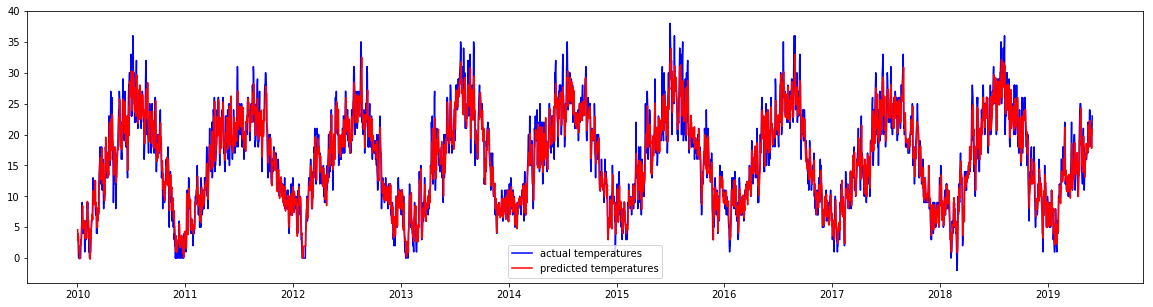

In [7]:
y_pred = best_estimator.predict(x_test)


def plot_meteo_pred(y_test, y_pred, dates):
    plt.figure(1, figsize=(20, 5))
    plt.plot(dates, y_test, label="actual temperatures", color="blue")
    plt.plot(dates, y_pred, label="predicted temperatures", color="red")
    plt.legend()
    plt.show()
    
plot_meteo_pred(y_test, y_pred, meteo_df_test["DATE"])

In [8]:
from sklearn.metrics import mean_squared_error
print("mean squared error: {}".format(mean_squared_error(y_pred, y_test)))
import math
print("root mean squared error: {}".format(math.sqrt(mean_squared_error(y_pred, y_test))))

mean squared error: 7.119540188536515
root mean squared error: 2.6682466506184386


root mean squared error 2010: 2.9063898408247493


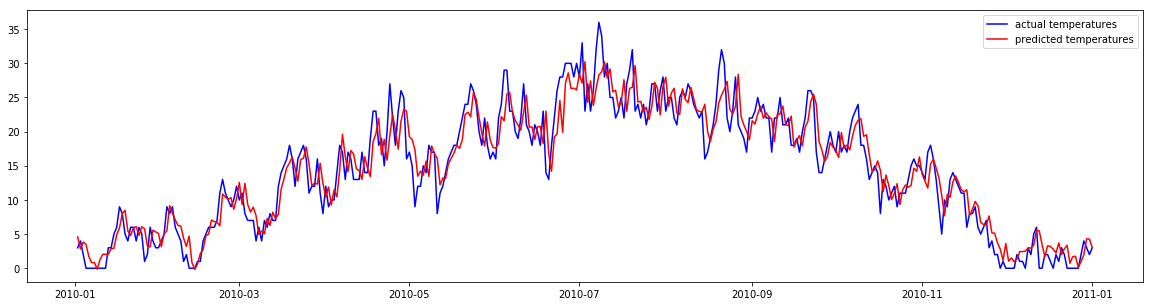

root mean squared error 2011: 2.63784534946066


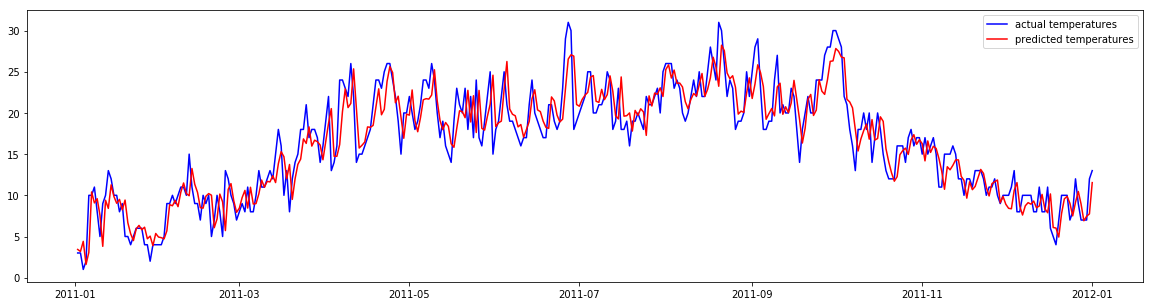

root mean squared error 2012: 2.4217800314124207


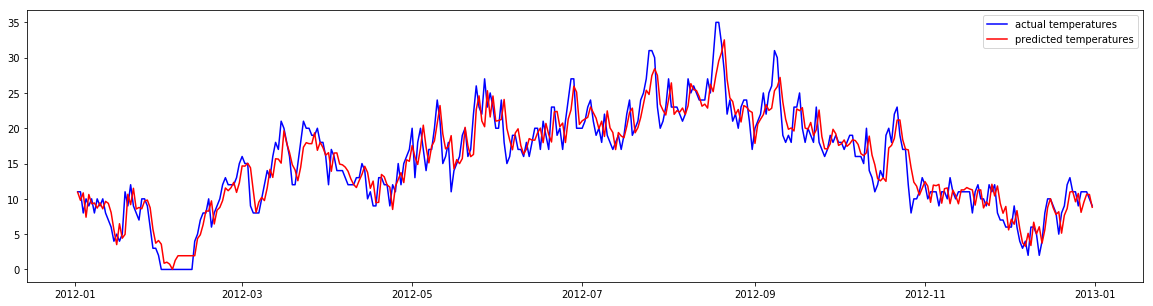

root mean squared error 2013: 2.719006313252481


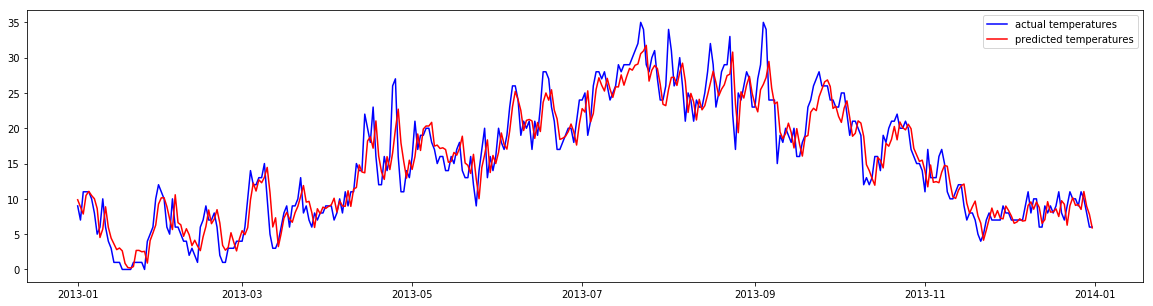

root mean squared error 2014: 2.557847684691603


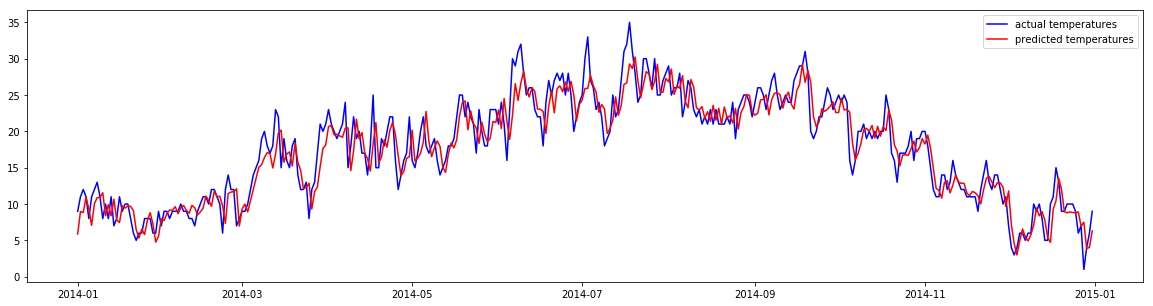

root mean squared error 2015: 3.0603186547307697


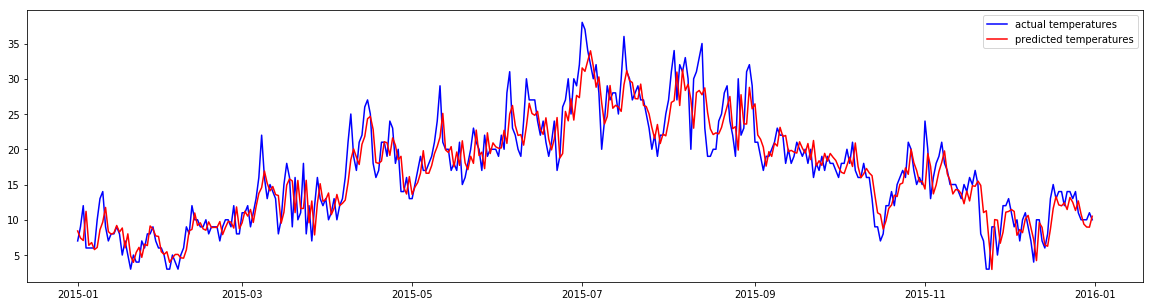

root mean squared error 2016: 2.4411151392934487


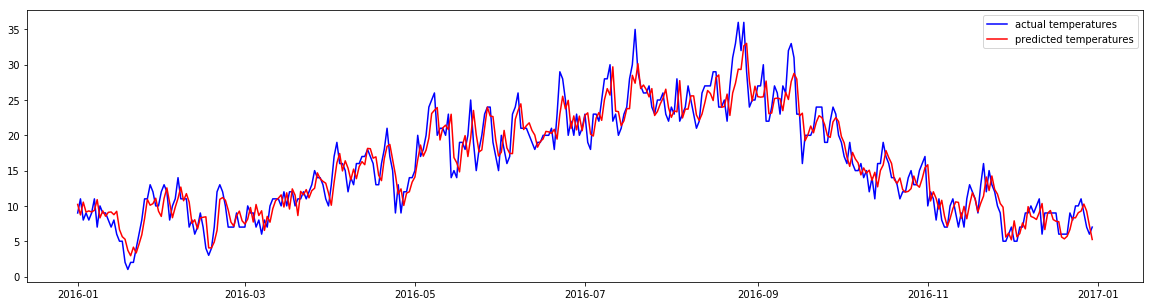

root mean squared error 2017: 2.4789928158068384


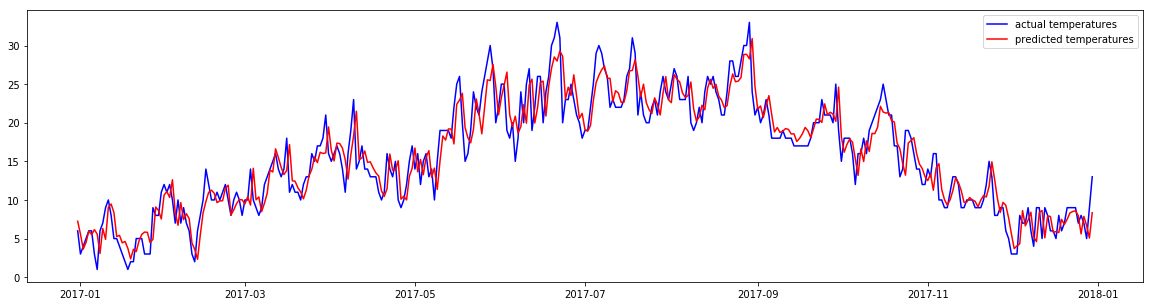

root mean squared error 2018: 2.8126672798959467


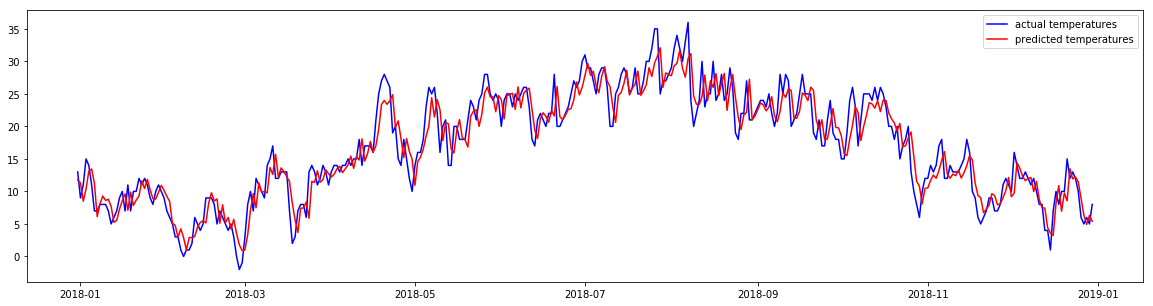

root mean squared error 2019: 2.4273600019254187


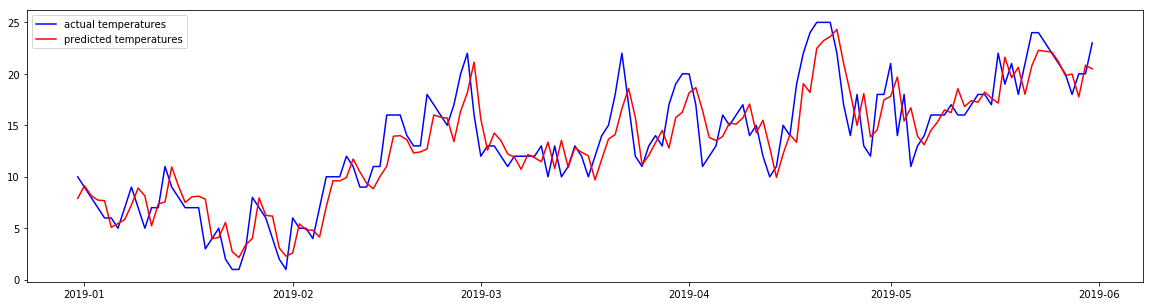

In [10]:
for i in range(10):
    year = 2010 + i
    y_test_year = y_test[i*365:min(len(y_test), (i+1)*365)]
    y_pred_year = y_pred[i*365:min(len(y_pred), (i+1)*365)]
    print("root mean squared error {}: {}".format(
        year,
        math.sqrt(mean_squared_error(y_pred_year, y_test_year))))
    
    dates = meteo_df_test["DATE"].values[i*365:min(len(y_test), (i+1)*365)]
    plot_meteo_pred(y_test_year, y_pred_year, dates)

In [ ]:
len(y_pred_year)